In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scanpy as sc
from scipy.stats import median_abs_deviation

# sklearn module
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

In [3]:
y_train

['T_cells_CD4+', 'T_cells_CD4+', 'T_cells_CD4+', 'T_cells_CD4+', 'T_cells_CD8+', ..., 'T_cells_CD4+', 'T_cells_CD8+', 'T_cells_CD4+', 'T_cells_CD8+', 'T_cells_CD8+']
Length: 1000
Categories (4, object): ['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']

In [4]:
X_train

<1000x13551 sparse matrix of type '<class 'numpy.float32'>'
	with 1091156 stored elements in Compressed Sparse Row format>

#### Labels proportions

In [5]:
lab_df = pd.DataFrame({'label': y_train})
lab_df.value_counts(normalize=True)

label       
T_cells_CD8+    0.342
T_cells_CD4+    0.336
Cancer_cells    0.237
NK_cells        0.085
dtype: float64

In [6]:
# check NA labels
lab_df.isna().sum()

label    0
dtype: int64

<AxesSubplot: >

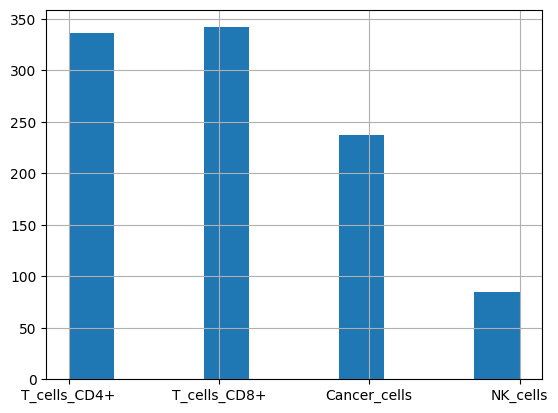

In [7]:
# Label hsitogram
lab_df.label.hist()

The labels indicates that the classes are imbalanced and there is no cell without labeling

In [8]:
# convert to array
X_train = X_train.toarray()
X_train

array([[1., 0., 0., ..., 3., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Data Preprocessing

In [10]:
total_cell_counts = X_train.sum(axis=1) # total counts per cell
number_genes_by_counts = (X_train > 0).sum(axis=1) # Number of expressed genes with positive counts in a cell

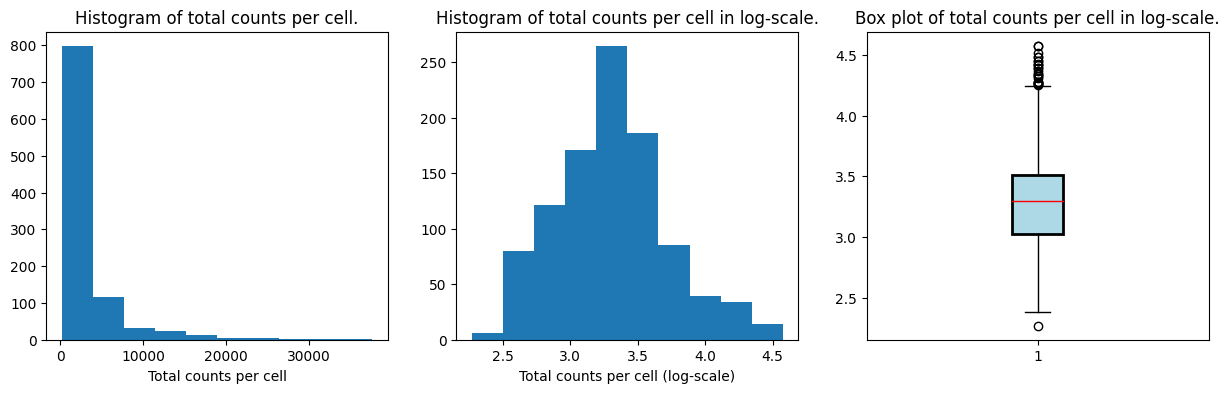

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
axes[0].hist(total_cell_counts)
axes[0].set_title("Histogram of total counts per cell.")
axes[0].set_xlabel('Total counts per cell')

axes[1].hist(np.log10(total_cell_counts)) 
axes[1].set_title("Histogram of total counts per cell in log-scale.")
axes[1].set_xlabel('Total counts per cell (log-scale)')

#axes[1].violinplot(np.log10(total_cell_counts))
axes[2].boxplot(np.log10(total_cell_counts), patch_artist=True, 
                   boxprops=dict(facecolor='lightblue', linewidth=2.0),
                   capprops=dict(linewidth=1.0),
                   whiskerprops=dict(linewidth=1.0),
                   flierprops=dict(linewidth=1.0),
                   medianprops=dict(linewidth=1.0, color = 'red'))
axes[2].set_title("Box plot of total counts per cell in log-scale.")
plt.show()
# plt.savefig('./figures/Total_cells_counts_dist.png')

In [13]:
total_genes_counts = X_train.sum(axis=0) # total counts per gene
number_cells_by_counts = (X_train != 0).sum(axis=0) # number of cells that each gene expressed

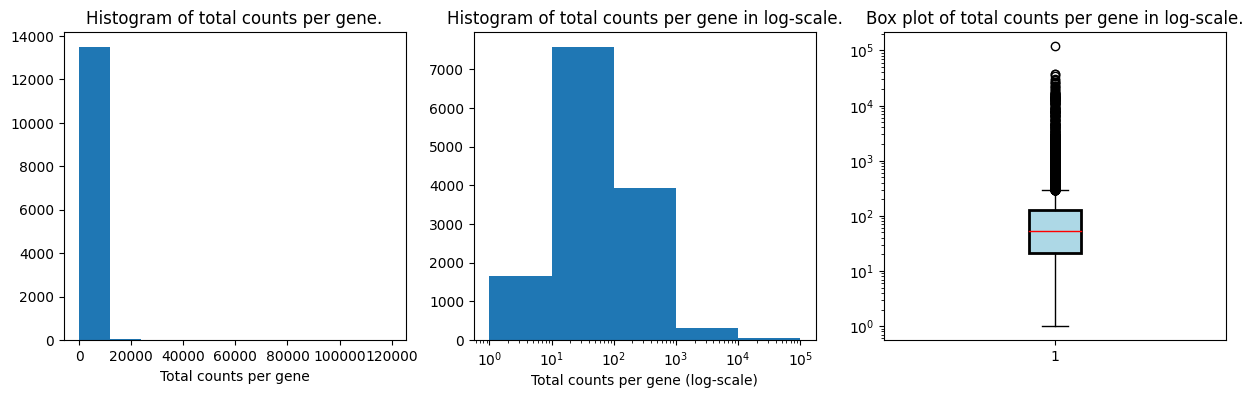

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
axes[0].hist(total_genes_counts)
axes[0].set_title("Histogram of total counts per gene.")
axes[0].set_xlabel('Total counts per gene')

axes[1].hist(total_genes_counts, bins = 10**np.arange(6))
axes[1].set_xscale("log")
axes[1].set_title("Histogram of total counts per gene in log-scale.")
axes[1].set_xlabel('Total counts per gene (log-scale)')

#axes[1].violinplot(np.log10(total_genes_counts), showmedians=True)
axes[2].boxplot(total_genes_counts, patch_artist=True, 
                   boxprops=dict(facecolor='lightblue', linewidth=2.0),
                   capprops=dict(linewidth=1.0),
                   whiskerprops=dict(linewidth=1.0),
                   flierprops=dict(linewidth=1.0),
                   medianprops=dict(linewidth=1.0, color = 'red'))
axes[2].set_title("Box plot of total counts per gene in log-scale.")
axes[2].set_yscale("log")
plt.show()
# plt.savefig('./figures/Total_genes_counts_dist.png')

The distribution suggests for some normalization of the counts. There are some genes that appear in very small quantities compared to other genes, as well as some genes that appear in very large quantities. Some cells have small number of genes compared to the others and somes have many genes. Therefore, we will do the quality control to filtering the initial data before normalization and prediction

## Quality control (Filtering data)

Before classification, we will examine to remove poor quality cells to reduce noise in the dataset. A cell has a low total counts, a low number of expressed genes might have a broken membrane which can indicate a dying cell. Since these cells might distort our prediction, we will remove them.

To identify them, we need thresholds for the total counts and the number of expressed genes. We can set a fixed threshold, but it needs experience in biology. Therefore, we will consider automatic thresholding via MAD (median absolute deviations), which is given by:

$$ MAD = median(|X_i-median(X)|) $$

where $X_i$ being the metrics (total counts, number of expressed genes, etc.) of an observation cell.

Reference to [Germain et al., 2020], we eliminate poor quality cells if they differ by 5 MADs which is a relatively permissive filtering strategy. In this case, because the distribution of total counts and number of expressed genes are not normal distribution so we removed based on the natural logarithm transformation of $(1+x)$ ($ln(1+x)$) where $x$ is the total counts or number of expressed genes. Moreover, we also include 1 quality control **pct_counts_top20_genes** in the **scanpy document**, which is the percentage of total counts that are attributed to the top 20 most highly expressed genes.

In [16]:
log1p_total_cells_counts = np.log1p(total_cell_counts)
log1p_number_genes_by_counts = np.log1p(number_genes_by_counts)

# Identify the top 20 genes
top20_genes = np.argsort(np.array(X_train.sum(axis=0)).ravel())[::-1][:20]

# Calculate the total counts in the top 20 genes for each cell
total_counts_top20_genes = np.sum(X_train[:, top20_genes], axis=1)

# Calculate the percentage of counts in the top 20 genes for each cell
pct_counts_top20_genes = total_counts_top20_genes / total_cell_counts

In [17]:
# Function to identify poor quality cells
def outlier_cells(X, num_mads):
    outliers = (X < np.median(X) - num_mads * median_abs_deviation(X))\
          | (np.median(X) + num_mads * median_abs_deviation(X) < X)
    return outliers

cells_remove = (outlier_cells(log1p_total_cells_counts, 5) 
                | outlier_cells(log1p_number_genes_by_counts, 5) 
                | outlier_cells(pct_counts_top20_genes, 5))

X_train = X_train[(~cells_remove), :].copy()
y_train = y_train[~cells_remove].copy()

In [18]:
X_train.shape

(991, 13551)

In [16]:
y_train.shape

(991,)

## Normalization

We try out some normalization method:
- Normalization by rows
- CPM (Counts per million)
- Shifted logarithm (log transformation) with total count equal to the median of total counts

In [17]:
# Normalization by rows
def norm_row(X):
    return X / X.sum(axis=1)[:, np.newaxis]

X_train_norm1 = norm_row(X_train)
# sanity check
np.allclose(X_train_norm1.sum(axis=1), np.ones(X_train_norm1.shape[0]))

True

In [18]:
# CPM (Counts per million)
def norm_cpm(X):
    # Calculate the total read counts per cells
    total_counts_per_cell = np.sum(X, axis=1)
    
    # Calculate the total read counts per million (CPM) for each sample
    total_counts_per_million = total_counts_per_cell / 1e6
    
    # Divide the count matrix by the total counts per million for each sample
    return X / total_counts_per_million[:, np.newaxis]

X_train_norm2 = norm_cpm(X_train)
# sanity check
np.allclose(X_train_norm2.sum(axis=1), np.full(X_train_norm2.shape[0],1e6))

True

In [19]:
# Shifted Logarithm (log transformation)
def norm_log(X):
    # Calculate the total counts per cell
    total_counts_cell = np.sum(X, axis=1)
    
    # Calculate the median of total counts
    med_total_counts = np.median(total_counts_cell)
    
    # Scale the counts to have a total count equal to the median of total counts
    scaled_counts = (X / total_counts_cell[:, np.newaxis]) * med_total_counts

    # Logarithm transformation
    return np.log1p(scaled_counts)

X_train_norm3 = norm_log(X_train)

We show the distributions of total counts after normalization

In [20]:
total_cell_counts_norm1 = X_train_norm1.sum(axis=1)
total_cell_counts_norm2 = X_train_norm2.sum(axis=1)
total_cell_counts_norm3 = X_train_norm3.sum(axis=1)

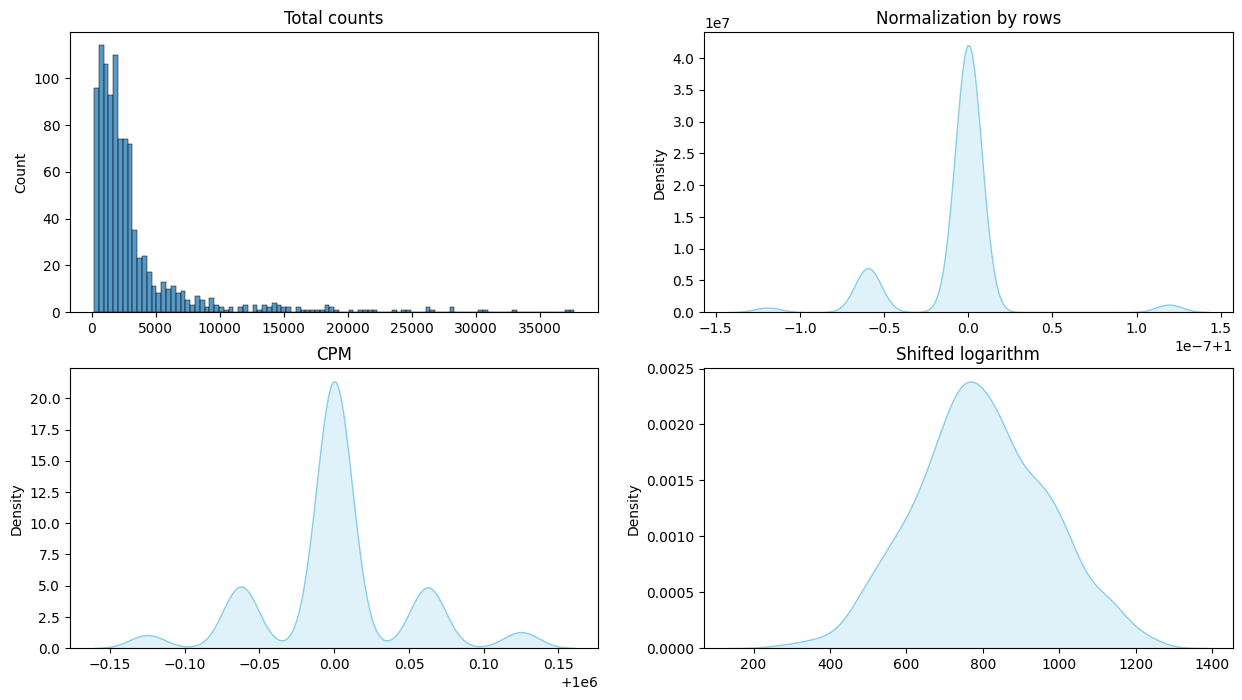

In [21]:
import math
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
p1 = sns.histplot(total_cell_counts, bins=100, kde=False, ax=axes[0][0])
axes[0][0].set_title("Total counts")

p2 = sns.kdeplot(total_cell_counts_norm1, color='skyblue', fill=True, ax=axes[0][1])
axes[0][1].set_title("Normalization by rows")
#p3 = sns.histplot(math.log(total_cell_counts_norm2, 100), bins = 100, kde=False, ax=axes[1][0])
p3 = sns.kdeplot(total_cell_counts_norm2, color='skyblue', fill=True, ax=axes[1][0])
axes[1][0].set_title("CPM")
p4 = sns.kdeplot(total_cell_counts_norm3, color='skyblue', fill=True, ax=axes[1][1])
#p4 = sns.histplot(total_cell_counts_norm3, bins=100, kde=False, ax=axes[1][1])
axes[1][1].set_title("Shifted logarithm")
plt.show()

Regarding the density graphs after normalization, we decided to choose the Shifted logarithm to normalize the data

## Feature Selection

We try some feature selection methods

### Using Binomial Deviance

Single-cell RNA sequencing (scRNA-seq) experiments primarily target a single tissue, yielding a limited set of genes that contribute to significant biological diversity. Traditional analysis methods typically select 500-2000 genes based on coefficient of variation or average expression, heavily reliant on the pre-analysis normalization technique.

Previously, normalization involved Counts Per Million (CPM) and log transformation. However, exact zeros in the data pose a challenge for log transformation. To resolve this, analysts often add a small pseudo count (e.g., 1 using log1p) before log transformation. Nevertheless, the arbitrary choice of this count can introduce biases, impacting subsequent analysis and gene feature selection. Low pseudo count values near zero can amplify variance in genes with zero counts, as observed by [Townes et al. in 2019.]

To address this, [Germain et al.] introduce a different strategy for choosing features by utilizing deviance directly on the original counts. This calculation of deviance helps determine if genes portray a steady expression pattern across cells. Genes exhibiting stable expression follow a multinomial null model, which is approximated using the binomial deviance. Genes with high deviance values suggest they don't conform to a consistent expression pattern across cells, indicating their high informativeness. The method organizes genes by their deviance values and exclusively selects those demonstrating substantial deviance, presenting an alternative method to the conventional gene selection approaches in scRNA-seq analysis.

the binomial deviance as an approximation:

$$D_{j} = 2\sum_{i}\left[y_{ij}\log\frac{y_{ij}}{n_{i}\hat{\pi}_{j}} + (n_{i}-y_{ij})\log\frac{(n_{i}-y_{ij})}{n_{i}(1-\hat{\pi}_{j})}\right]
$$
Where $D_{j}$ indicated the deviance of each genes.

To compute the binomial deviances of each genes, we have interpreted it as a function in `binomial_deviance.py` base on this [source code](https://github.com/ktpolanski/scanpy/blob/deviantgenes/scanpy/preprocessing/_highly_deviant_genes.py)

In [22]:
from binomial_deviance import binomial_deviance

In [23]:
# compute binomial deviances on the original count matrix
X_devi = binomial_deviance(X_train)
X_devi

array([1232.2039 ,  395.23163,  153.30315, ..., 1065.9568 ,  413.3513 ,
        260.66254], dtype=float32)

In [24]:
# It shown that some genes' deviance values are null due to the original count those genes are zero
X_train[:,np.isnan(X_devi)].sum(axis=0)
# So we will set those values to zero
X_devi[np.isnan(X_devi)] = 0

In [25]:
# Identify the highly deviance genes indices 
# Here we going to select top 4000 genes
n_top_genes = 4000
highly_deviance_indices = np.argsort(X_devi)[::-1][:n_top_genes]

In [26]:
# So we can use that indices to select the the highly informative genes base on the n top genes we choose on the normalized data
X_train_devi = X_train[:,highly_deviance_indices] # original data with high informative genes
X_train_norm1_devi = X_train_norm1[:,highly_deviance_indices]
X_train_norm2_devi = X_train_norm2[:,highly_deviance_indices]
X_train_norm3_devi = X_train_norm3[:,highly_deviance_indices]

In [27]:
total_count_devi = X_train_devi.sum(axis=1)
total_cell_counts_norm1_devi = X_train_norm1_devi.sum(axis=1)
total_cell_counts_norm2_devi = X_train_norm2_devi.sum(axis=1)
total_cell_counts_norm3_devi = X_train_norm3_devi.sum(axis=1)

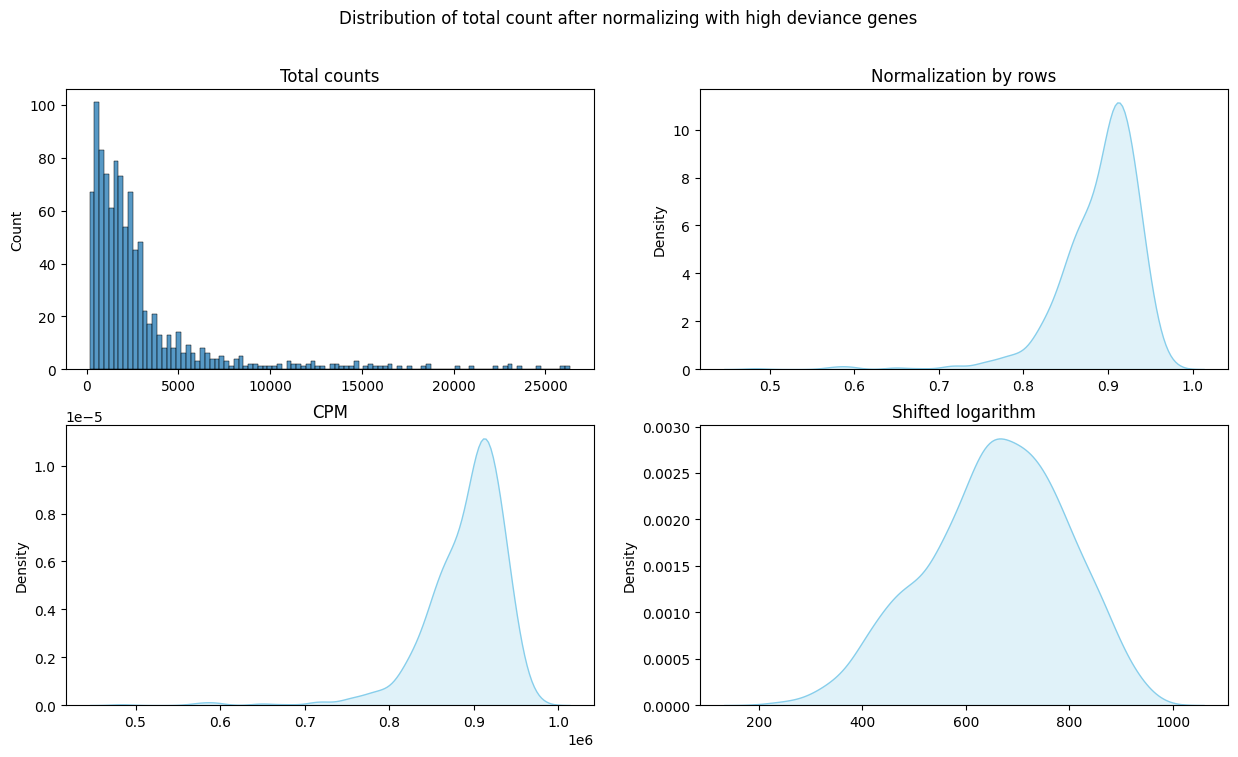

In [28]:
import math
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
p1 = sns.histplot(total_count_devi, bins=100, kde=False, ax=axes[0][0])
axes[0][0].set_title("Total counts")

p2 = sns.kdeplot(total_cell_counts_norm1_devi, color='skyblue', fill=True, ax=axes[0][1])
axes[0][1].set_title("Normalization by rows")

p3 = sns.kdeplot(total_cell_counts_norm2_devi, color='skyblue', fill=True, ax=axes[1][0])
axes[1][0].set_title("CPM")

p4 = sns.kdeplot(total_cell_counts_norm3_devi, color='skyblue', fill=True, ax=axes[1][1])
axes[1][1].set_title("Shifted logarithm")

fig.suptitle("Distribution of total count after normalizing with high deviance genes")
plt.show()

According to the density graphs, the shifted algorithm is still quite good in normalizing data.

### Using Highly Variable Genes (HVGs)

This method was referenced from (Lun, McCarthy, and Marioni 2016). We identify a set of top highly variable genes (HVGs), which can be used to define major cell types. This method were originally developed for single-cell RNA sequencing (scRNA-seq) data. The selection based on the dispersion (seurat method) or the variance of gene expression

In [22]:
def HVGs(data, proportion=0.1, flavor='seurat'):
    """
    Parameters:
        - proportion: percentages of top highly variable genes to keep.
        - flavor: 'seurat' or 'cell_ranger'. Determines the method used for calculating dispersion.
    """
    # Calculate mean and dispersion
    mean_expr = np.mean(data, axis=0)
    dispersion = np.var(data, axis=0) / mean_expr if flavor == 'seurat' else np.var(data, axis=0)

    # Get the number of genes to select
    num_genes = int(proportion * data.shape[1])

    # Get indices of top highly variable genes
    hvg_indices = np.argsort(dispersion)[::-1][:num_genes]

    data_hvgs = data[:,hvg_indices]

    return data_hvgs

In [24]:
X_train_norm3_hvg = HVGs(X_train_norm3, proportion=0.1, flavor=None) # select proportion of top highly variable genes (HVGs)
X_train_norm3_hvg.shape # Check number of genes kept

(991, 1355)

<AxesSubplot: ylabel='Density'>

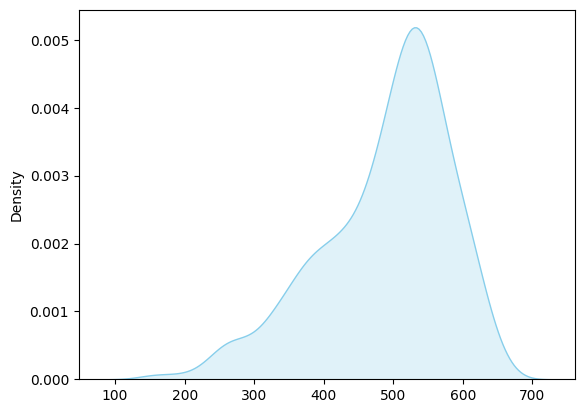

In [25]:
total_cell_counts_norm3_hvg = X_train_norm3_hvg.sum(axis=1)
sns.kdeplot(total_cell_counts_norm3_hvg, color='skyblue', fill=True)

## Dimension Reduction

After selecting the most informative genes using the binomial deviance and HVGs methods, the dataset still has a high dimensionality which can negatively impact the performance of prediction model. Therefore, it is necessary to reduce dimension of the dataset in order to minimize noise, computing resource, and also enhance model performance.

### Principle Component Analysis (PCA)

We know that the scRNA-seq datasets are sparse due to many dropout events, and they are highly non-linear. Even though the linear dimension reduction technique PCA is inappropriate for visualizing, selecting the top 10-50 PCs may be sufficient for downstream analysis.

In [26]:
# standardize X_train_norm3_devi
std = StandardScaler()
X_std = std.fit_transform(X_train_norm3_hvg)
# init PCA with 50 components
pca = PCA(n_components=50)
# compute PCA
X_pca = pca.fit_transform(X_std)

In [27]:
# Retrieve information from X_pca
n_components = len(pca.explained_variance_ratio_)
explained_variance = pca.explained_variance_ratio_
# cumulative sum of explained variance
cumsum_exp_var = np.cumsum(explained_variance)
# scale components index
idx = np.arange(n_components)+1
# print information
df_pca = pd.DataFrame([explained_variance, cumsum_exp_var], index=['explained_variance', 'cumulative'], columns=idx).T
print("The first 5 component:\n\n", df_pca.head(5))
print("="*35)
print("The last 5 component:\n\n", df_pca.tail(5))

The first 5 component:

    explained_variance  cumulative
1            0.039646    0.039646
2            0.035217    0.074863
3            0.026342    0.101205
4            0.012758    0.113963
5            0.011229    0.125192
The last 5 component:

     explained_variance  cumulative
46            0.002792    0.285713
47            0.002762    0.288475
48            0.002744    0.291219
49            0.002719    0.293938
50            0.002692    0.296630


<AxesSubplot: xlabel='PC_1', ylabel='PC_2'>

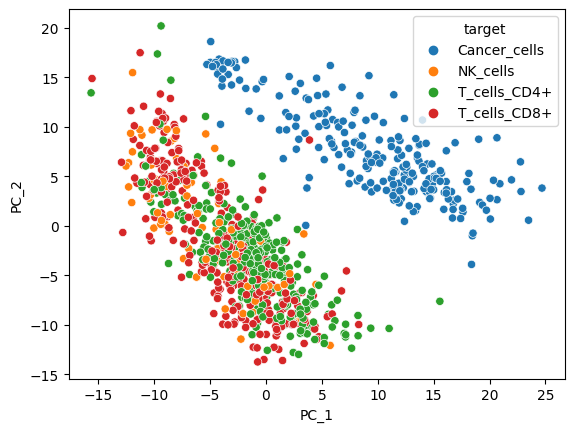

In [28]:
# scatter plot of PC1 and PC2
tab_pca = pd.DataFrame(X_pca)
tab_pca = pd.concat([tab_pca, pd.Series(y_train)], axis=1)
column_names = [f'PC_{i}' for i in range(1, 51)] + ['target']
tab_pca.columns = column_names

sns.scatterplot(x=tab_pca['PC_1'], y=tab_pca['PC_2'], data=tab_pca, hue=tab_pca['target'])

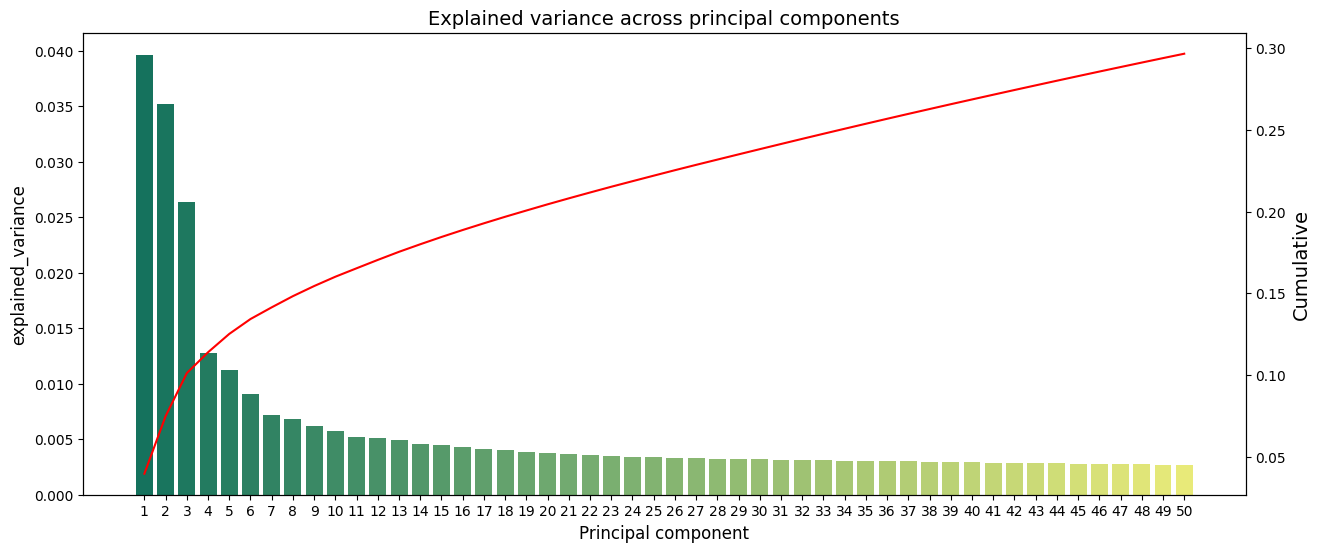

In [29]:
# Scree plot
#make scree plot
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.set_title('Explained variance across principal components', fontsize=14)
ax1.set_xlabel('Principal component', fontsize=12)
ax1.set_ylabel('Explained variance', fontsize=12)
ax2 = sns.barplot(x=idx, y='explained_variance', data=df_pca, palette='summer')
ax2 = ax1.twinx()
ax2.grid(False)
ax2.set_ylabel('Cumulative', fontsize=14)
ax2 = sns.lineplot(x=idx-1, y='cumulative', data=df_pca, color='red')

plt.show()

Based on the graph, it appears that the first components are only able to capture approximately 9% of the explained variances, which is considered to be a relatively low percentage. In overall, the 50 components can capture approximately 84.6% information of the original data, which is significant for downstream analysis.

### t-SNE (T-distributed Stochastic Neighbor Embedding)

In [36]:
from sklearn.manifold import TSNE
# init t-SNE 2d
tsne = TSNE(n_components=2, random_state=0)
X_std_tsne = std.fit_transform(X_train_norm3_hvg)
X_tsne_2d = tsne.fit_transform(X_std_tsne)
tsne.kl_divergence_

1.139509677886963

In [37]:
# t-SNE for 3 components
tsne = TSNE(n_components=3, random_state=0)
X_std_tsne = std.fit_transform(X_train_norm3_hvg)
X_tsne_3d = tsne.fit_transform(X_std_tsne)
tsne.kl_divergence_

0.9948272109031677

<AxesSubplot: xlabel='t-SNE 1', ylabel='t-SNE 2'>

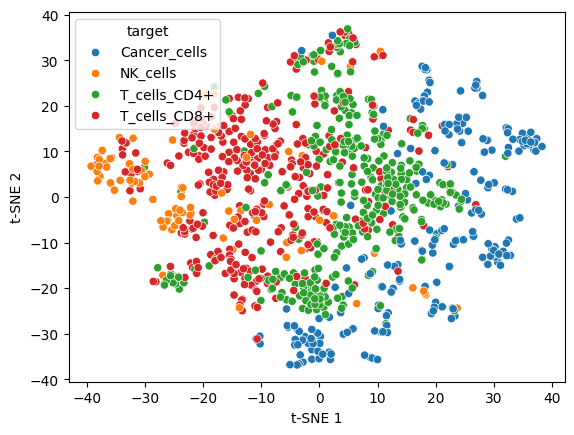

In [38]:
# Scatter plot for t-SNE
tab_tsne = pd.DataFrame(X_tsne_2d)
tab_tsne = pd.concat([tab_tsne, pd.Series(y_train)], axis=1)
column_names = [f't-SNE {i}' for i in range(1, 3)] + ['target']
tab_tsne.columns = column_names

sns.scatterplot(x=tab_tsne['t-SNE 1'], y=tab_tsne['t-SNE 2'], data=tab_tsne, hue=tab_tsne['target'])

### UMAP (Uniform Manifold Approximation and Projection)

In [39]:
def UMAP_reduction(data, components=50):
    from umap import UMAP
    
    umap_model = UMAP(n_components = components, random_state=0)
    dimension_data = umap_model.fit_transform(data)

    return dimension_data

X_train_norm3_devi_hvg_umap = UMAP_reduction(X_train_norm3_devi_hvg, components = 50)

c:\Users\Dzo\miniconda3\envs\data-camp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Dzo\miniconda3\envs\data-camp\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


# Training Models

In [ ]:
from sklearn.model_selection import StratifiedKFold

def cross_valid(model, X, Y, K):
    # K-fold splitting
    skf = StratifiedKFold(n_splits=K)

    # test results
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    tprs = []
    mean_fpr = np.linspace(0,1,100)
    aucs=[]
    for train_index, valid_index in skf.split(X,Y):
        # retrieve data 
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = Y[train_index], Y[valid_index]

        # fit training data into model
        modelfit = model.fit(X_train, y_train)
        prediction = modelfit.predict(X_valid) # predict on test set

        # compute accuracy, precision, recall, and f1_score for test set
        accuracy_list.append(accuracy_score(y_valid, prediction))
        precision_list.append(precision_score(y_valid, prediction))
        recall_list.append(recall_score(y_valid, prediction))
        f1_list.append(f1_score(y_valid, prediction))

    return accuracy_list, precision_list, recall_list, f1_list